# Logistic regression
Logistic regression is one of the most used classification algorithm. For binary classification, its basic idea is to model the probability of $Y=1$ by the distribution
$$ Pr(Y = 1|X=x) = \frac{\exp{(x^T \beta)}}{1 + \exp{(x^T \beta)}} $$
where $ \beta$ is the parameter.As a consequence the probability of $Y=0$ is
$$ Pr(Y = 0|X=x) = \frac{1}{1 + \exp{(x^T \beta)}}$$
If we denote $Pr(Y = 1|X=x)$ as $p(x)$, for a given observation $(x, y)$, the probability is
$$ p(y|x) = p(x)^y (1 - p(x))^{(1-y)} $$
For the data set $X = \{x_1, \dots, x_N \} $ and $Y = \{y_1, \dots, y_N \}$, the log-likelihood is
$$\begin{align}
&\ell(\beta)\\
= & \log \left\{\prod_{i=1}^N p(y_i|x_i) \right\}\\
= & \sum_{i=1}^N y_i \log (p(x_i)) + (1 - y_i) \log (1 - p(x_i))\\
= & \sum_{i=1}^N y_i \log \frac{p(x_i)}{1 - p(x_i)} + \log(1 - p(x_i))\\
= & \sum_{i=1}^N y_i (x_i^T \beta) - \log{(1 + \exp{(x_i^T \beta)})}
\end{align}$$

## First order optimization
To obtain a maximum-likelihood estimation (MLE), we can use gradient ascent method. The derivative of the log-likelihood with respect to the parameter $\beta$ is
$$\begin{align}
& \frac{d \ell}{d \beta}\\
=& \sum_{i=1}^N y_i x_i - \frac{\exp{(x_i^T \beta)} x_i}{1 + \exp{(x_i^T \beta)}}\\
=& \sum_{i=1}^N (y_i - p(x_i)) x_i\\
\end{align}$$
Then we can update the parameter using
$$ \beta \leftarrow \beta + \epsilon \frac{d \ell}{d \beta} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/apple/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The implementation of the above algorithm is as follows

In [2]:
class LRFirstOrder():
    def __init__(self):
        pass
    
    def calProb(self, X, beta):
        z = np.dot(X, beta)
        # z = z.reshape((len(z), 1))
        prob = np.exp(z)/(1 + np.exp(z))
        return prob
    
    def calLogLike(self, X, y, beta):
        loglike = np.dot(y.T, np.dot(X, beta)) - np.sum(np.log(1 + np.exp(np.dot(X, beta))))
        return loglike[0,0]
        
    def fit(self, X, y, numIter = 1000, eta = 0.01, epsi = 1e-3):
        nObs = X.shape[0]
        if (len(y) != nObs):
            raise ValueError('Number of observations in X and y not match!')
        
        if (len(X.shape) != 2):
            raise ValueError('X is not a 2 dimensional matrix!')
        
        # Add intercept
        newX = np.hstack((np.ones((len(y), 1)), X))
        # Construct beta
        beta = np.zeros((newX.shape[1], 1))
        newY = y.reshape((len(y), 1))
        
        self.loglikelihood_ = []
        self.beta_ = []
        for i in range(numIter):
            prob = self.calProb(newX, beta)
            beta = beta + eta * np.dot(newX.T, (newY - prob))
            self.beta_.append(beta)
            self.loglikelihood_.append(self.calLogLike(newX, newY, beta))
            
        self.betaFin_ = beta
        
        if (self.loglikelihood_[-2] > self.loglikelihood_[-1] or
            (self.loglikelihood_[-2] - self.loglikelihood_[-1])/np.abs(self.loglikelihood_[-1]) > epsi):
            print "Algorithm not converged!"
    
    def predict(self, X, threshold = 0.5):
        newX =np.hstack((np.ones(y.shape, 1), X))
        prob = self.calProb(newX, beta)
        return np.where(prob > threshold, 1, 0)

Now we generate the simulated data with the parameter $\beta = (-1, 0.8, -0.3)^T $

In [3]:
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

x1 = np.arange(-5, 5, 0.1)
x2 = np.arange(-5, 5, 0.1)
x1v, x2v = np.meshgrid(x1, x2)
x1v = x1v.reshape((10000, 1))
x2v = x2v.reshape((10000, 1))

prob = sigmoid(-1 + 0.8*x1v - 0.3 * x2v)
np.random.seed(112)
y = np.random.binomial(1,prob)
X = np.hstack((x1v, x2v))

In [4]:
lrOne = LRFirstOrder()
lrOne.fit(X, y, eta = 0.00001)

After training, we new inspect the correctness of the fitting algorithm.

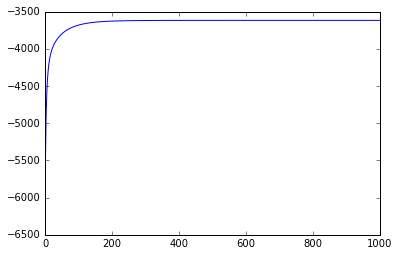

In [5]:
plt.plot(lrOne.loglikelihood_)

In [6]:
lrOne.betaFin_

array([[-1.03717157],
       [ 0.81243949],
       [-0.3013197 ]])

From the above, it is clear that the estimation is indeed good.

## Second order optimization
The gradient ascent method is good, but we can accelerate its convergence by using second order derivative information. The method is usually Newton method, and its general algorithm is
$$ \beta \leftarrow \beta - (\nabla^2 \ell(\beta))^{-1}\ell'(\beta) $$
For logistic regression, the second order derivative is
$$ \nabla^2 \ell(\beta) = - \sum_{i=1}^N p(x_i)(1 - p(x_i)) x_i x_i^t $$

Now here is the implementation:

In [7]:
class LRSecondOrder:
    def __init__(self):
        pass
    
    def calProb(self, X, beta):
        z = np.dot(X, beta)
        prob = np.exp(z)/(1 + np.exp(z))
        return prob
    
    def calLogLike(self, X, y, beta):
        loglike = np.dot(y.T, np.dot(X, beta)) - np.sum(np.log(1 + np.exp(np.dot(X, beta))))
        return loglike[0,0]
    
    def fit(self, X, y, numIter = 1000, eta = 0.01, epsi = 0.0001):
        nObs = X.shape[0]
        if (len(y) != nObs):
            raise ValueError('Number of observations in X and y not match!')
        
        if (len(X.shape) != 2):
            raise ValueError('X is not a 2 dimensional matrix!')
        
        # Add intercept
        newX = np.hstack((np.ones((len(y), 1)), X))
        # Construct beta
        beta = np.zeros((newX.shape[1], 1))
        newY = y.reshape((len(y), 1))
        
        self.loglikelihood_ = []
        self.beta_ = []
        
        for i in range(numIter):
            prob = self.calProb(newX, beta)
            deriv1 = np.dot(newX.T, (newY - prob))
            deriv2 = -np.dot(np.dot(newX.T, np.diag((prob*(1-prob))[:, 0])), newX)
            beta = beta - np.dot(np.linalg.inv(deriv2), deriv1)
            self.beta_.append(beta)
            self.loglikelihood_.append(self.calLogLike(newX, newY, beta))
        
        self.betaFin_ = beta
    
    def predict(self, X, threshold = 0.5):
        newX =np.hstack((np.ones(y.shape, 1), X))
        prob = self.calProb(newX, beta)
        return np.where(prob > threshold, 1, 0)

Fitting the same data we get

In [8]:
lrTwo = LRSecondOrder()
lrTwo.fit(X, y, numIter = 20)

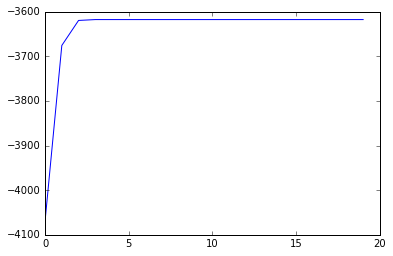

In [9]:
plt.plot(lrTwo.loglikelihood_)

In [10]:
lrTwo.betaFin_

array([[-1.03737435],
       [ 0.81249534],
       [-0.30134122]])

The estimated parameter is also good. And we can compare the convergence speed of the first order algorithm and second order algorithm.

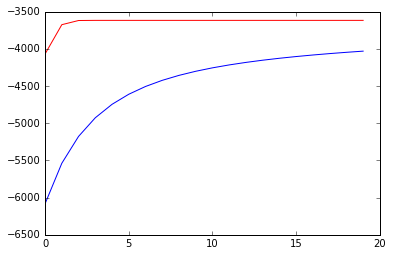

In [11]:
plt.plot(lrTwo.loglikelihood_, color = 'r')
plt.plot(lrOne.loglikelihood_[:20], color = 'b')

It is thus seen that the second order algrithm does converge faster than the first order algorithm.